<a href="https://colab.research.google.com/github/m-a-rahal/face-emotion-pfe2022/blob/main/attention_net_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Attention with TensorFlow 2.x 
![simple_nn](media/miscellaneous/tf_logo.png "TF Logo")

# 1.0 Attention & Visual Attention

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Copyright 2021 Vittorio Mazzia. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

def plotImages(images_batch, img_n, classes):
    """
    Take as input a batch from the generator and plt a number of images equal to img_n
    Default columns equal to max_c. At least inputs of batch equal two
    """
    max_c = 5
    
    if img_n <= max_c:
        r = 1
        c = img_n
    else:
        r = math.ceil(img_n/max_c)
        c = max_c
        
    fig, axes = plt.subplots(r, c, figsize=(15,15))
    axes = axes.flatten()
    for img_batch, label_batch, ax in zip(images_batch[0], images_batch[1], axes):
        ax.imshow(img_batch)
        ax.grid()
        ax.set_title('Class: {}'.format(classes[label_batch]))
    plt.tight_layout()
    plt.show()

def plotHistory(history):
    """
    Plot the loss and accuracy curves for training and validation 
    """
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1.5)
    plt.show()


def explainGradCam(explainer, ax, img, y, model_1, y_pred_1, model_2, y_pred_2, class_names):
    """
    [Attention Episode]
    Plot GRADCAM of two trained models. It needs an axes with two columns
    """
    data = ([img], None)
    
    y_predm_1 = np.argmax(y_pred_1)
    y_predm_2 = np.argmax(y_pred_2)
        
    grid_1 = explainer.explain(data, model_1, class_index=y_predm_1, image_weight=0.8)
    grid_2 = explainer.explain(data, model_2, class_index=y_predm_2, image_weight=0.8)

    ax[0].set_xlabel("Pred: {} {:2.0f}% ({})".format(class_names[y_predm_1],
                                100*np.max(y_pred_1),
                                class_names[y]),
                                color=('blue' if y == y_predm_1 else 'red'))

    
    ax[1].set_xlabel("Pred: {} {:2.0f}% ({})".format(class_names[y_predm_2],
                                100*np.max(y_pred_2),
                                class_names[y]),
                                color=('blue' if y == y_predm_2 else 'red'))
    ax[0].imshow(grid_1)
    ax[1].imshow(grid_2)

In [4]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tfconfig.experimental.set_visible_devices(gpus[0], 'GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

## 1.1 Neural Machine Translation by Jointly Learning to Align and Translate

<a>https://arxiv.org/abs/1409.0473</a>

![visual_attention_exampels](media/tf_tutorial_2/yoshua_paper_results.png "Attention Examples")

## 1.2 Show, Attend and Tell: Neural Image Caption Generation with Visual Attention

<a>https://arxiv.org/abs/1502.03044</a>

![visual_attention_exampels](media/tf_tutorial_2/attention_examples.png "Attention Examples")

## 1.3 Squeeze-and-Excitation Networks
<a>https://arxiv.org/abs/1709.01507</a>

![visual_attention_exampels](media/tf_tutorial_2/se_example_1.png "Attention Examples")
![visual_attention_exampels](media/tf_tutorial_2/se_example_2.png "Attention Examples")

# 2.0 Example of Visual Attention

## 2.1 CBAM: Convolutional Block Attention Module
<a>https://arxiv.org/abs/1807.06521</a>

![visual_attention_exampels](media/tf_tutorial_2/cbam_example_1.png "Attention Examples")
![visual_attention_exampels](media/tf_tutorial_2/cbam_example_2.png "Attention Examples")

In [5]:
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
            

            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)
            
            return tf.keras.layers.Multiply()([inputs, attention])

In [6]:
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            
            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention]) 

# 3.0 Build a Model

## 3.1 Download a dataset (CIFAR 10)

In [8]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteXIUDIB/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteXIUDIB/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


### 3.1.1 Visualize the dataset

In [9]:
ds_info

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)

In [10]:
ds_info.features['label'].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

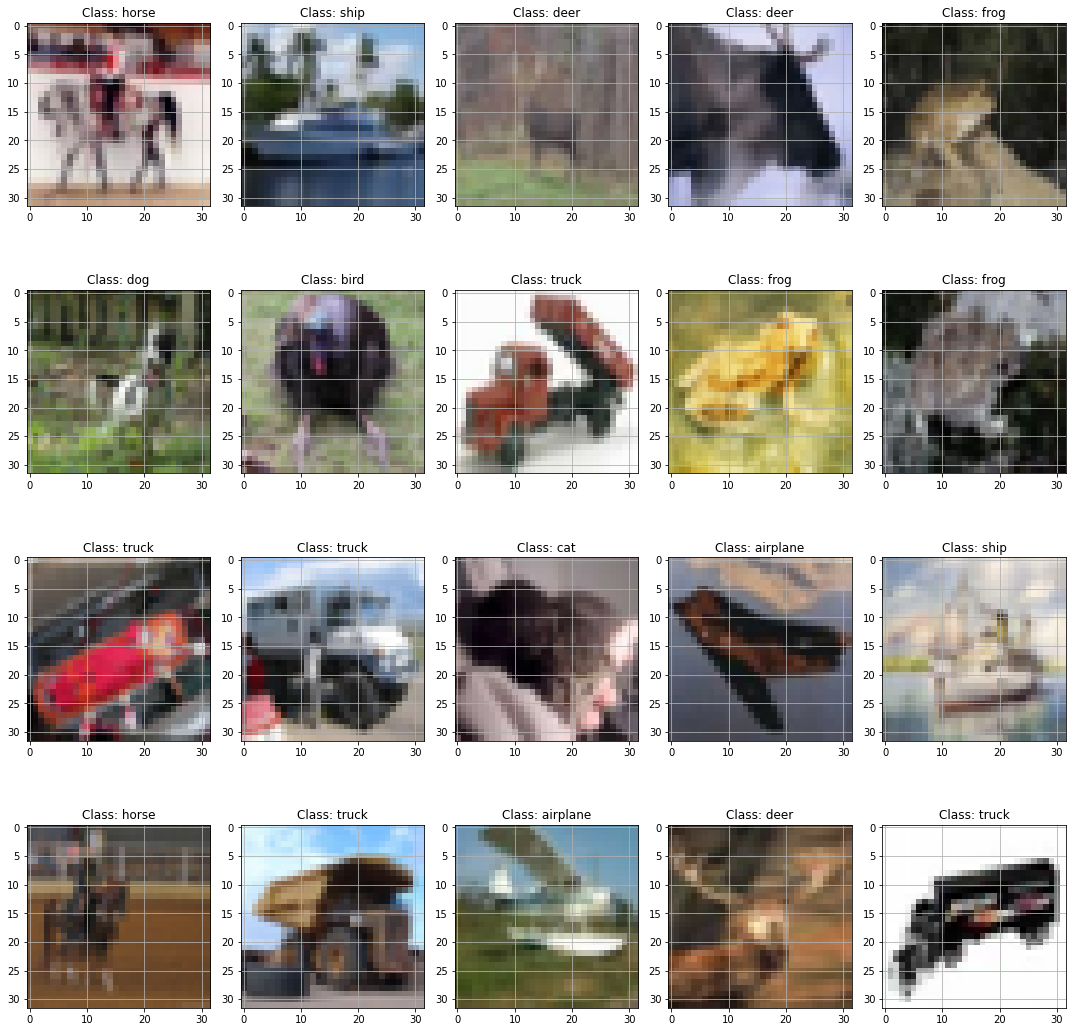

In [11]:
for data in ds_train.batch(20):
    plotImages(data, 20, ds_info.features['label'].names)
    break

### 3.1.2 Build a dataset pipeline

In [11]:
def normalize(image, label):
    return tf.cast(image, tf.float32) / 255., label

In [12]:
ds_train = ds_train.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
ds_test = ds_test.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(32)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## 3.2 Build a network without attention

In [14]:
simple_cnn_no_attention = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, input_shape=ds_info.features['image'].shape, activation='elu', padding='same'),   
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='elu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax' )
])

In [ ]:
simple_cnn_no_attention.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        3

In [15]:
simple_cnn_no_attention.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [16]:
history = simple_cnn_no_attention.fit(ds_train, epochs=20)

Epoch 1/20
1563/1563 [==============================] - 26s 6ms/step - loss: 1.1897 - accuracy: 0.5745
Epoch 2/20
1563/1563 [==============================] - 9s 5ms/step - loss: 0.7707 - accuracy: 0.7326
Epoch 3/20
1563/1563 [==============================] - 9s 5ms/step - loss: 0.6110 - accuracy: 0.7879
Epoch 4/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.5009 - accuracy: 0.8242
Epoch 5/20
1563/1563 [==============================] - 9s 5ms/step - loss: 0.4228 - accuracy: 0.8527
Epoch 6/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.3504 - accuracy: 0.8774
Epoch 7/20
1563/1563 [==============================] - 9s 5ms/step - loss: 0.2942 - accuracy: 0.8953
Epoch 8/20
1563/1563 [==============================] - 9s 5ms/step - loss: 0.2448 - accuracy: 0.9136
Epoch 9/20
1502/1563 [===========================>..] - ETA: 0s - loss: 0.1962 - accuracy: 0.9299

KeyboardInterrupt: ignored

In [17]:
plotHistory(history)

NameError: ignored

In [18]:
print(f"Test accuracy: {simple_cnn_no_attention.evaluate(ds_test)[1]}")

313/313 [==============================] - 3s 8ms/step - loss: 0.7600 - accuracy: 0.7821
Test accuracy: 0.7821000218391418


## 3.3 Builid a network with attention

In [19]:
simple_cnn_with_attention = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, input_shape=ds_info.features['image'].shape, activation='elu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    ChannelAttention(32, 8),
    SpatialAttention(7),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    ChannelAttention(64, 8),
    SpatialAttention(7),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    ChannelAttention(128, 8),
    SpatialAttention(7),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax' )
])

In [20]:
simple_cnn_with_attention.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 channel_attention (ChannelA  (None, 32, 32, 32)       0         
 ttention)                                                       
                                                      

In [21]:
simple_cnn_with_attention.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [22]:
history = simple_cnn_with_attention.fit(ds_train, epochs=20)

Epoch 1/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.1754 - accuracy: 0.5803
Epoch 2/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7591 - accuracy: 0.7350
Epoch 3/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.6008 - accuracy: 0.7905
Epoch 4/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.5006 - accuracy: 0.8249
Epoch 5/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.4186 - accuracy: 0.8535
Epoch 6/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.3509 - accuracy: 0.8768
Epoch 7/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.2937 - accuracy: 0.8959
Epoch 8/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.2400 - accuracy: 0.9167
Epoch 9/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.2006 - accuracy: 0.9291
Epoch 10/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.16

KeyboardInterrupt: ignored

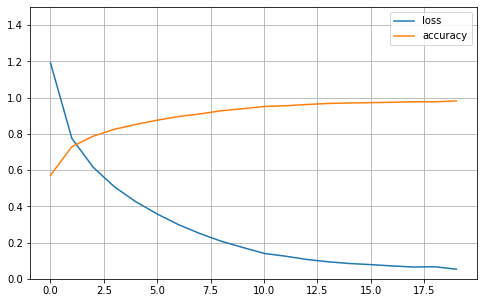

In [ ]:
plotHistory(history)

In [ ]:
print(f"Test accuracy: {simple_cnn_with_attention.evaluate(ds_test)[1]}")

313/313 [==============================] - 1s 4ms/step - loss: 0.8654 - accuracy: 0.8236
Test accuracy: 0.8235999941825867


# 4.0 Visualize Network Attention

In [ ]:
from tf_explain.core.grad_cam import GradCAM

In [ ]:
explainer = GradCAM()

In [ ]:
for images, labels in tfds.as_numpy(ds_test.take(1)):
    X_test = images
    y_test = labels

In [ ]:
print(X_test.shape, y_test.shape)

(32, 32, 32, 3) (32,)


## 4.1 Network without vs with attention

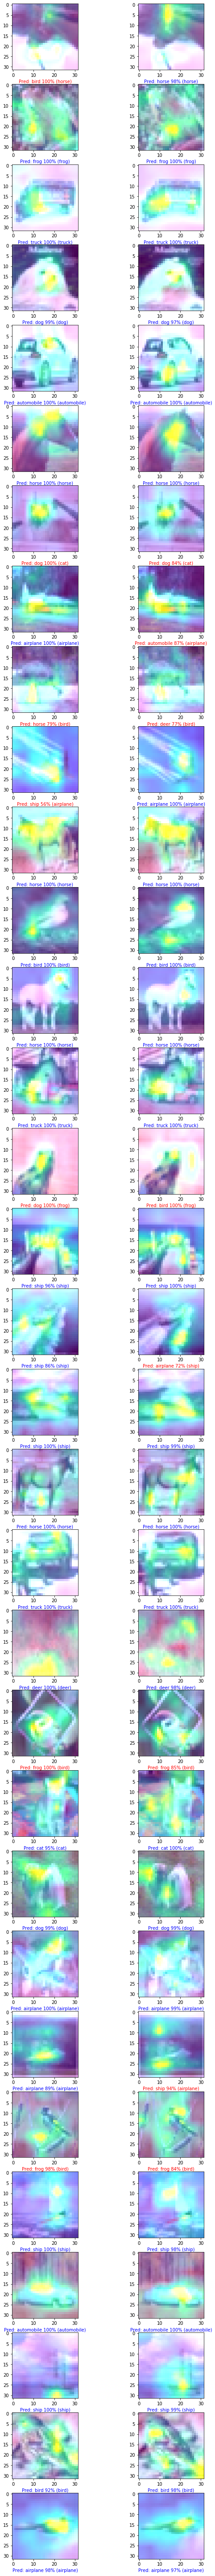

In [ ]:
fig, axes = plt.subplots(32, 2, figsize=(8,80))
fig.tight_layout()
index = 0
for img, label in zip(X_test, y_test):
    explainGradCam(explainer, axes[index], img,
               label,
               simple_cnn_no_attention,
               simple_cnn_no_attention.predict(img[None]), 
               simple_cnn_with_attention,
               simple_cnn_with_attention.predict(img[None]), 
               class_names=ds_info.features['label'].names)
    index += 1